# Detection, tracking and location of runways on visual approaches

projeto realizado para o curso "EA979 - INTRODUÇÃO À COMPUTAÇÃO GRÁFICA E AO PROCESSAMENTO DE IMAGEM"

- Daniel Gonçalves Benvenutti 169448
- Matteo Di Fabio 264339
- Renan Sterle 176536

## Introduction and Motivation

Both in military aviation as well as in civil aviation, visual flight rules (VFR) remain of great importance nowadays. Particularly in airports and terminals of reduced infrastructure, visual approach and landing procedures account for the majority of cases and such procedures rely on visibility conditions, visual navigational aids and personal performance of the pilot in command. Figure 1 depicts what a final visual approach looks like.

In any type of landing approach, the maintenance of a safe flight envelope is crucial. Therefore, during the final approach leg, parameters such as airspeed, altitude, descent rate, glide slope, ground clearance, as well as location in relation to the runway must be monitored and corrected.

While airspeed, altitude and descent rate are measure by the aircraft, the other parameters can only be determined with the use of external information. In the case of instrument flight rules (IFR), Instrument Landing Systems (ILS), Global Navigation Satellite System (GNSS), inertial navigation systems and radio beacons provide such information, whereas on VFR they are ultimately estimated visually by the pilot.

This project is the implementation of a system that:

1. Given a picture of an approach, identifies and isolates the runway in question, using image processing filtering and segmentation techniques;
2. Fits the runway image into the expected runway shape by applying perspective and affine transformations;
3. Determines the camera point of view in relation to the runway start. Alignment, lateral offset and distance information are the most important, while relative altitude is of secondary importance;


##### imported library

In [115]:
import sys;
import os;
import numpy as NP;
from PIL import Image;
import matplotlib;
#matplotlib.use("GTK3Agg");
import matplotlib.pyplot as PLT;
import json;


import cv2;
import numpy as np;
import operator;
import copy;

#import os.path;


## Correct perspective
This modules uses both Pillow and numpy frameworks to correct the perspective of the runway given its vertex and expected dimension.

It first rotates the image in order to make the runway’s center line vertical. Then, the center offset is determined as the average of the upper and lower start and end lines. Following, a shear transformation makes the lower start line horizontal;

The next step is a perspective transformation that makes the upper end line parallel and aligned to the lower start line. After a crop, the image of the runway is a rectangle. Finally, a resize transformation brings it to the correct aspect ratio. For demonstration, the aspect ratio is artificially wider at a ratio of 2,5 to make the visualization easier.

In [116]:

def PerspectiveCoefficients(A, B):
    matrix = [];
    for p1, p2 in zip(A, B):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]]);
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]]);

    A = NP.matrix(matrix, dtype=NP.float)
    B = NP.array(B).reshape(8)

    res = NP.dot(NP.linalg.inv(A.T * A) * A.T, B)
    return NP.array(res).reshape(8)

def Correction(I, Points, Width, Length):
    L0 = NP.array(Points["L0"]);
    R0 = NP.array(Points["R0"]);
    L1 = NP.array(Points["L1"]);
    R1 = NP.array(Points["R1"]);

    C0 = (L0+R0)/2.0;
    C1 = (L1+R1)/2.0;
    C = (C0+C1)/2.0;
    D = C0-C1;
    Angle = NP.arctan2(D[0], D[1]);

    #Rotate image:
    I = I.rotate(NP.degrees(-Angle), Image.BICUBIC, False, (C[0], C[1]));

    #Rotate points:
    Cos, Sin = NP.cos(Angle), NP.sin(Angle);
    Rotation = NP.array(((Cos, -Sin), (Sin, Cos)));
    [L0, R0, L1, R1, C_] = NP.transpose(NP.matmul(Rotation, NP.c_[L0, R0, L1, R1, C]));

    #Correct center offset:
    D = C-C_;
    [L0, R0, L1, R1] = [L0, R0, L1, R1]+D;

    D = R0-L0;
    ShearFactor = D[1]/D[0];
    #Shear image:
    Shear = NP.eye(3);
    Shear[1][0] = ShearFactor;
    I = I.transform(I.size, Image.AFFINE, Shear.flatten()[:6], Image.BICUBIC);

    #Shear points:
    Shear = NP.eye(2);
    Shear[1][0] = -ShearFactor;
    [L0, R0, L1, R1] = NP.transpose(NP.matmul(Shear, NP.c_[L0, R0, L1, R1]));

    #Crop image:
    Y0 = (R0[1]+L0[1])/2.0;
    Y1 = (R1[1]+L1[1])/2.0;
    X0 = L0[0];
    X1 = X0+R0[0]-L0[0];
    I = I.crop((X0, Y1, X1, Y0));

    D = NP.array([X0, Y1]);
    [L0, R0, L1, R1] = [L0, R0, L1, R1]-D;

    #Perspective:
    W, H = I.size;
    T = PerspectiveCoefficients([(0, H), (W, H), (0, 0), (W, 0)], [L0, R0, L1, R1]);
    I = I.transform(I.size, Image.PERSPECTIVE, T.flatten()[:8], Image.BICUBIC);
    [L0, R0, L1, R1] = [(0, H), (W, H), (0, 0), (W, 0)];

    #Resize:
    AspectRatioFactor = 0.4;
    VScale = AspectRatioFactor*Length/Width;
    I = I.resize((I.size[0], int(VScale*I.size[1])), Image.ANTIALIAS)
    [L0, R0, L1, R1] = [(0, VScale*H), (W, VScale*H), (0, 0), (W, 0)];
    
    return I, NP.transpose(NP.vstack([L0, L1, R1, R0, L0]));

def Correct(JSON, ExportPath):
    #Opens original image:
    I = Image.open(JSON["Image"]);

    Runway = JSON["Runway"];
    Width = NP.array(Runway["Width"]);
    Length = NP.array(Runway["Length"]);

    A, PA = Correction(I, JSON["Runway"], Width, Length);
    B, PB = Correction(I, JSON["Results"], Width, Length);

    Figure = PLT.figure("Correction")
    F = Figure.add_subplot(1, 2, 1);
    F.imshow(A);
    F.plot(PA[0], PA[1]);
    F.title.set_text("Expected:");
    F = Figure.add_subplot(1, 2, 2);
    F.imshow(B);
    F.plot(PB[0], PB[1]);
    F.title.set_text("Obtained:");
    
    #Export plot:
    if (ExportPath is not None):
        Figure.savefig(ExportPath + "/10 Correct.png");

    PLT.show();


## Display function

Saves the original image with the expected and obtained boundaries of the runway.


In [117]:
def Display(JSON, ExportPath):
    Figure = PLT.figure("Identification")
    F = Figure.add_subplot(1, 1, 1);
    F.imshow(Image.open(JSON["Image"]));

    Runway = JSON["Runway"];
    L0 = Runway["L0"];
    R0 = Runway["R0"];
    L1 = Runway["L1"];
    R1 = Runway["R1"];

    P = NP.transpose(NP.vstack([L0, L1, R1, R0, L0]));

    #Plot expected:
    F.plot(P[0], P[1], label = "Expected boundary", color = "lime");
    F.legend();

    Results = JSON["Results"];
    L0 = Results["L0"];
    R0 = Results["R0"];
    L1 = Results["L1"];
    R1 = Results["R1"];

    P = NP.transpose(NP.vstack([L0, L1, R1, R0, L0]));

    #Plot obtained:
    F.plot(P[0], P[1], label = "Obtained boundary", color = "magenta");
    F.legend();

    PLT.title("Identification Results:")
    PLT.show();
    
    #Export plot:
    if (ExportPath is not None):
        Figure.savefig(ExportPath + "/09 Display.png");


## Find Position

The position of the airplane is found using the runway’s four vertex. The implementation uses a routine from OpenCV called  calibrateCamera that also executes the function  SolvePnP. In order to find the aircraft position, calibrateCamera takes several points with their coordinates in the image as well as in the real world. It is even possible to use several different images.

Hence, a calibration matrix (intrinsic matrix) is obtained regarding the camera in question. If many images are available, one can use this matrix in the equation for solve PnP and find, together with the above mentioned points, the matrices tvecs and rvecs of an image. Those are the extrinsic factors and also the translation and rotation vectors of the image and can be used to convert coordinates from the image space to the real world space.

Next, we make an operation with these vectors accordingly to this article on Wikipedia: https://en.wikipedia.org/wiki/Camera_resectioning#Extrinsic_parameters. 

Where C is the position of the camera in real world’s coordinates, R is the rotation matrix obtained from the rotation vector with OpenCV’s rotate function and T is the translation vector.

The quality of the values can be improved when various images are used together to obtain the camera calibration matrix. We chose, nevertheless, not to implement something in that sense due to limitation of test images, which are taken with several different cameras.

In [118]:
def find_position(JSON, image_path) :
    #gets image size
    image = Image.open(image_path)
    imageSize=image.size

    #runway image points
    L0= JSON['Results']['L0']
    R0= JSON['Results']['R0']
    L1= JSON['Results']['L1']
    R1= JSON['Results']['R1']
    imagePts=[R1,R0,L0,L1]
    
     #runway real world coordinates
    #dimensoes da pista
    Wid=JSON['Runway']["Width"]
    Len=JSON['Runway']["Length"]
    #real world coordinates of the edges of the runway
    posA=[Wid,Len,0]
    posB= [Wid,0,0]
    posC= [0,0,0]
    posD= [0,Len,0]

    runwayPoints=[posA,posB,posC,posD]
    #calibracao com https://www.learnopencv.com/camera-calibration-using-opencv/
    import cv2
    objectsPoints=np.array([runwayPoints], dtype='float32')
    imagesPoints=np.array([imagePts],dtype='float32')
    #finds the tranlation and rotation matrix for image points and real world coordinates
    retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objectsPoints, imagesPoints, imageSize, None, None)
    rvecs=rvecs[0]
    tvecs=tvecs[0]
    
    #rotation matrix from vector
    R_mtx, jac = cv2.Rodrigues(rvecs)
    #calculates the position of (0,0,0) which is the camera
    #in real world coordinates
    cameraPosition = -R_mtx.T * np.matrix(tvecs)
    #np.array(cameraPosition).T[0]
    #JSON['Results']['Plane_pos']=cameraPosition
    JSON['Results']['Plane_pos']=np.array(cameraPosition).T[0].tolist()
    return JSON

## IdentifyRunway Explanation

This modules uses both OpenCV and numpy frameworks, but no artificial intelligence. Given a picture of a runway on final approach, it’s task is to provide the coordinates of the four vertex of the runways bounding box.

The very ad hoc implementation is based on the following sequence of processing steps:

1. Contrast enhancement: The raw image has its contrast enhanced re-scaling its ABS data in order to make the runway more detectable. A constant positive Alpha and variable negative Beta are applied;
2. Bilateral Filtering: Two different settings of bilateral filtering are applied in parallel to the previous step. Both transformations have the purpose of making areas with similar colors more homogeneous, while keeping the runway edges sharp;
3. Canny Edge Detection: The algorithm is applied to the two results of the previous step and  the high gradients of color and intensity are reflected into a black and white image corresponding to the edges identified;
4. Crop: The Canny algorithm in some situations falsely identifies the borders of the image as edges of interest. This is never the case and makes the processing more complicated, as they tend to be long as straight, as the runway should look like. Therefore, a margin of all the image’s borders is cropped to reduce ambiguity;
5. Dilation: The many edges identified by the Canny algorithm are in many cases duplicate of the same edges of interest. In other cases, one notable edge is not fully identified but is instead identified as various segments close to each other. The dilation process fuses these edges in spatial proximity and reduces the complexity of the analysis without significant losses of information. As a result, the general noise is reduced;
6. Hough Transformation: This step identifies segments of line among the dilated edges of the last step. These segments are described by the coordinates of their vertex and stored in a list;
7. Line filtering: Not all line segments are interesting. Particularly those which are vertical or with small inclination are of no interest. Therefore, a threshold filtering is done based on the inclination angle;
8. Line plotting: All filtered lines, from both processing branches, are plotted to a blank image. The result of this step is similar to the one intended by the dilation step. Line segments close to each other are merged, while segments that are in fact part of a greater segment are unified. Again the noise and ambiguity are reduced;
9. Hough Transformation: This time, the Hough transformation is applied for the plotted lines instead of the dilated edges, providing a smaller and more significant set of line segments;
10. Optimization: From all segments lines of the previous step, all vertex are extracted. For all vertex, in turn, two pairs of points are chosen such that the shadow of the segments of line connecting such pairs maximizes the coverage of the plotted lines from step 8. Hence, the maximization of the shadow translates itself into the modeling of the runway edges.
11. Sorting: The points obtained need to be sorted in order to be used in the next stages of the pipeline. Therefore, they are converted to polar coordinates referenced to the mean of them, and sorted by the angle. Lastly, they are again converted to Cartesian coordinates;

In [119]:
def Cart2Pol(P):
    Rho = np.sqrt(P[0]**2 + P[1]**2);
    Phi = np.arctan2(P[1], P[0]);
    return ([Rho, Phi]);

def Pol2Cart(P):
    return([P[0] * np.cos(P[1]), P[0] * np.sin(P[1])]);

def IdentifyRunway(JSON, ExportPath):
    RawImage = cv2.imread(JSON["Image"]);
    Result = copy.copy(RawImage);

    # 1. Enhance contrast;
    Alpha = 3.0;
    Beta = -Alpha*np.mean(cv2.mean(RawImage)[0:3]);
    Contrast = cv2.convertScaleAbs(RawImage, alpha = Alpha, beta = Beta);

    # 2. Blur;
    sigmaColor = [40, 200];
    sigmaSpace = 10;
    Blur1 = cv2.bilateralFilter(Contrast, d = 0, sigmaColor = sigmaColor[0], sigmaSpace = sigmaSpace, borderType = cv2.BORDER_WRAP);
    Blur2 = cv2.bilateralFilter(Contrast, d = 0, sigmaColor = sigmaColor[1], sigmaSpace = sigmaSpace, borderType = cv2.BORDER_WRAP);

    # 3. Canny;
    Edges1 = cv2.Canny(Blur1, 100, 300);
    Edges2 = cv2.Canny(Blur2, 80, 150);

    # 4. Crop:
    Margin = 5;
    Edges1 = Edges1[Margin:-Margin, Margin:-Margin];
    Edges2 = Edges2[Margin:-Margin, Margin:-Margin];

    # 5. Dilatation:
    KernelSize = 3;
    Kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (KernelSize, KernelSize));
    Dilation1 = cv2.dilate(Edges1, Kernel, iterations = 1);
    Dilation2 = cv2.dilate(Edges2, Kernel, iterations = 1);

    # 6. Hough 1;
    Lines1 = cv2.HoughLinesP(Dilation1, 1, np.pi/180, threshold = 40, minLineLength = 60, maxLineGap = 5);
    Lines2 = cv2.HoughLinesP(Dilation2, 1, np.pi/180, threshold = 40, minLineLength = 60, maxLineGap = 5);

    # 7. Merge and filter lines;
    MinAngle = 30*np.pi/180;
    Lines = list();
    for X in Lines1:
        Delta = np.asarray([X[0][0], X[0][1]])-np.asarray([X[0][2], X[0][3]]);
        Angle = np.arctan(Delta[1]/Delta[0]);
        if (np.abs(Angle) > MinAngle):
            Lines.append(X[0]);
            
    for X in Lines2:
        Delta = np.asarray([X[0][0], X[0][1]])-np.asarray([X[0][2], X[0][3]]);
        Angle = np.arctan(Delta[1]/Delta[0]);
        if (np.abs(Angle) > MinAngle):
            Lines.append(X[0]);

    # 8. Line processing:
    Edges = np.zeros(Edges1.shape, np.uint8);
    LineWidth = 4;
    for L in Lines:
        cv2.line(Result, (L[0]+Margin, L[1]+Margin), (L[2]+Margin, L[3]+Margin), (0, 255, 0), 1);
        cv2.line(Edges, (L[0]+Margin, L[1]+Margin), (L[2]+Margin, L[3]+Margin), (255, 255, 255), LineWidth);
        cv2.circle(Result, (L[0]+Margin, L[1]+Margin), 2, (255, 0, 0), -1);
        cv2.circle(Result, (L[2]+Margin, L[3]+Margin), 2, (255, 0, 0), -1);

    # 9. Hough 2:
    Lines = cv2.HoughLinesP(Edges, 1, np.pi/180, threshold = 20, minLineLength = 40, maxLineGap = 8);
    DrawnEdges = cv2.cvtColor(Edges, cv2.COLOR_GRAY2RGB);
    for X in Lines:
        cv2.line(DrawnEdges, (X[0][0]+Margin, X[0][1]+Margin), (X[0][2]+Margin, X[0][3]+Margin), (0, 0, 255), 1);

    # 10. Modelling:
    Max = 0;
    BestI = 0;
    BestJ = 0;
    LineWeight = 8;
    for I, X in enumerate(Lines):
        for J, Y in enumerate(Lines):
            print(I, len(Lines), end = '\r');
            TmpEdges = copy.copy(Edges);
            cv2.line(TmpEdges, (X[0][0]+Margin, X[0][1]+Margin), (X[0][2]+Margin, X[0][3]+Margin), (0, 0, 0), LineWeight);
            cv2.line(TmpEdges, (Y[0][0]+Margin, Y[0][1]+Margin), (Y[0][2]+Margin, Y[0][3]+Margin), (0, 0, 0), LineWeight);
            Count = np.count_nonzero(TmpEdges == 0);
            if (Count > Max):
                Max = Count;
                BestI = I;
                BestJ = J;
    print("");

    X = Lines[BestI][0];
    Y = Lines[BestJ][0];
    
    #Cartesian coordinates:
    A = (X[0]+Margin, X[1]+Margin);
    B = (X[2]+Margin, X[3]+Margin);
    C = (Y[0]+Margin, Y[1]+Margin);
    D = (Y[2]+Margin, Y[3]+Margin);

    #Draw results:
    cv2.line(DrawnEdges, A, B, (255, 0, 255), 5);
    cv2.line(DrawnEdges, C, D, (255, 0, 255), 5);
    cv2.circle(Result, A, 5, (0, 255, 255), -1);
    cv2.circle(Result, B, 5, (0, 255, 255), -1);
    cv2.circle(Result, C, 5, (0, 255, 255), -1);
    cv2.circle(Result, D, 5, (0, 255, 255), -1);

    A = np.asarray(A);
    B = np.asarray(B);
    C = np.asarray(C);
    D = np.asarray(D);
    Center = (A+B+C+D)/4;

    #Sort vertex:
    Vertex = list();
    Vertex.append(Cart2Pol(A-Center));
    Vertex.append(Cart2Pol(B-Center));
    Vertex.append(Cart2Pol(C-Center));
    Vertex.append(Cart2Pol(D-Center));
    Vertex.sort(key = lambda X: X[1]);
    
    #Add results to JSON:
    JSON["Results"] = dict();
    JSON["Results"]["L0"] = (Pol2Cart(Vertex[3])+Center).tolist();
    JSON["Results"]["R0"] = (Pol2Cart(Vertex[2])+Center).tolist();
    JSON["Results"]["L1"] = (Pol2Cart(Vertex[0])+Center).tolist();
    JSON["Results"]["R1"] = (Pol2Cart(Vertex[1])+Center).tolist();
    
    #Show results:
    cv2.imshow("RawImage", RawImage);
    cv2.imshow("Contrast", Contrast);
    cv2.imshow("Blur1", Blur1);
    cv2.imshow("Blur2", Blur2);
    cv2.imshow("Edges1", Edges1);
    cv2.imshow("Edges2", Edges2);
    cv2.imshow("Drawn Edges", DrawnEdges);
    cv2.imshow("Result", Result);
    
    #Export images:
    if (ExportPath is not None):
        cv2.imwrite(ExportPath+"/01 Image.jpg", RawImage);
        cv2.imwrite(ExportPath+"/02 Contrast.jpg", Contrast);
        cv2.imwrite(ExportPath+"/03 Blur1.jpg", Blur1);
        cv2.imwrite(ExportPath+"/04 Blur2.jpg", Blur2);
        cv2.imwrite(ExportPath+"/05 Edges1.jpg", Edges1);
        cv2.imwrite(ExportPath+"/06 Edges2.jpg", Edges2);
        cv2.imwrite(ExportPath+"/07 DrawnEdges.jpg", DrawnEdges);
        cv2.imwrite(ExportPath+"/08 Result.jpg", Result);

    cv2.waitKey(0);
    cv2.destroyAllWindows();

    return JSON;

## Main explanation

Using this code we have a main that use the python library wrote by us. This main read the image into the Path variable and create a folder named Results inside the folder where is this notebook and after that create a folder with the same name of the image where we can fine all the image processed to achieve the final result.
Instead of writing a aprameter into the command line, we only need to change the value of the variable  Path

/home/matteo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in int_scalars


216 21717


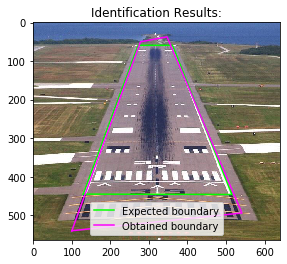

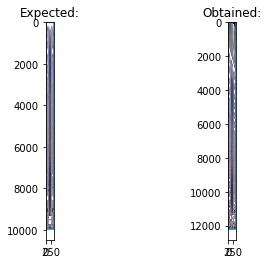

In [120]:
def ReadJSON(JSONPath, Path):
    File = open(JSONPath, "r");
    Data = json.loads(File.read());
    Data["Image"] = Path;
    File.close();
    return Data;

def Main():
    Path='../DataSet/Selected/Real/01.jpg'
    #Path='../DataSet/Selected/Simulation/07.jpg'
    ExportPath = './Results' + '/' + os.path.splitext(os.path.basename(Path))[0]
    
    if (not os.path.exists('./Results')):
        os.makedirs('./Results', exist_ok = True);
    
    if (not os.path.exists(ExportPath)):
        os.makedirs(ExportPath, exist_ok = True);
                           
    JSONPath = os.path.splitext(Path)[0]+".txt";
    if (not os.path.exists(Path)):
        sys.exit("File does not exist.");
    if (not os.path.exists(JSONPath)):
        sys.exit("JSON file does not exist.");

    JSON = ReadJSON(JSONPath, Path);
    JSON = IdentifyRunway(JSON, ExportPath);
    JSON = find_position(JSON, Path);
    #print (JSON)
    Display(JSON, ExportPath);
    Correct(JSON, ExportPath);
    
    #Export JSON:
    if (ExportPath is not None):
        File = open(ExportPath + "/11 JSON.txt", "w");
        json.dump(JSON, File, indent = 4);
        File.close();
        
if (__name__ == "__main__"):
    Main()

## Conclusion
Given the limitations of the tools and techniques used in face of the complexity of the problem, the results are quite satisfying. The implementation is able to detect the runway several different scenarios of environment, lighting, morphology of runway, proximity and so on. The correction of perspective works as well, but is notably very sensitive to the precision of the runway detection. Also, in some cases of the real world test images it is possible to notice how non-flat runways affect negatively the result.
One surprising conclusion is that the system does not work as well for the simulated test cases. Although the scenarios are more controlled and homogeneous, the reduced amount of noise and distortions from the real world makes the analysis more complex, ambiguous and prone to failure. We believe a big factor that contributes to this phenomenon is that the simulation images tend to have many more straight lines, as in the horizon, taxiways, buildings, contours and landscape.